## Import Packages

In [5]:
import numpy as np
import pandas as pd
import os
from pathlib import Path
from typing import Tuple, List, Dict, Optional, Callable, Any
from dataclasses import dataclass

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms, models
from torchvision.transforms import functional as TF

from sklearn.metrics import (
    classification_report, confusion_matrix, precision_score,
    recall_score, f1_score, roc_auc_score, roc_curve,
    precision_recall_curve, average_precision_score
)

from PIL import Image, ImageFile
import cv2
import warnings

## Set up training

In [6]:
warnings.filterwarnings('ignore')
ImageFile.LOAD_TRUNCATED_IMAGES = True


@dataclass
class Config:
    """Training configuration"""
    train_dir: str = 'data/train'
    test_dir: str = 'data/test'
    output_dir: str = 'data/working'
    
    batch_size: int = 16
    img_size: int = 224
    num_epochs: int = 10
    learning_rate: float = 0.0001
    weight_decay: float = 0.05
    num_workers: int = 4
    
    train_split: float = 0.8
    patience: int = 5
    min_delta: float = 0.001
    
    device: torch.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    class_to_idx: Dict[str, int] = None
    classes: List[str] = None
    
    def __post_init__(self):
        self.class_to_idx = {'Real': 0, 'Fake': 1}
        self.classes = ['Real', 'Fake']
        Path(self.output_dir).mkdir(parents=True, exist_ok=True)


config = Config()

print(f"Device: {config.device}")
if torch.cuda.is_available():
    print(f"GPU Count: {torch.cuda.device_count()}")
    for i in range(torch.cuda.device_count()):
        print(f"  GPU {i}: {torch.cuda.get_device_name(i)}")

Device: cuda
GPU Count: 1
  GPU 0: NVIDIA GeForce RTX 3070 Ti Laptop GPU


## Import and set up dataset

In [7]:
class ImageDataset(Dataset):
    """Custom dataset with Real/Fake mapping (Real=0, Fake=1)"""
    
    def __init__(
        self,
        root_dir: str,
        transform: Optional[Callable] = None,
        loader: Optional[Callable] = None
    ) -> None:
        self.root_dir = Path(root_dir)
        self.transform = transform
        self.loader = loader or self._default_loader
        
        self.class_to_idx = {'Real': 0, 'Fake': 1}
        self.classes = ['Real', 'Fake']
        self.samples: List[Tuple[str, int]] = []
        
        self._scan_directory()
    
    def _scan_directory(self) -> None:
        """Scan directory and build samples list"""
        for class_name in os.listdir(self.root_dir):
            class_path = self.root_dir / class_name
            
            if not class_path.is_dir():
                continue
            
            if class_name.lower() == 'real':
                class_idx = 0
            elif class_name.lower() == 'fake':
                class_idx = 1
            else:
                print(f"Warning: Unknown class '{class_name}', skipping...")
                continue
            
            for img_name in os.listdir(class_path):
                if img_name.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
                    img_path = str(class_path / img_name)
                    self.samples.append((img_path, class_idx))
        
        print(f"Found {len(self.samples)} images")
        print(f"Classes: {self.classes}")
        print(f"Mapping: {self.class_to_idx}")
    
    @staticmethod
    def _default_loader(path: str) -> Image.Image:
        """Robust image loader with error handling"""
        try:
            with open(path, 'rb') as f:
                img = Image.open(f)
                return img.convert('RGB')
        except Exception as e:
            print(f"Error loading {path}: {e}")
            return Image.new('RGB', (224, 224), color='black')
    
    def __len__(self) -> int:
        return len(self.samples)
    
    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, int]:
        """Returns: (image_tensor, label) where label: 0=Real, 1=Fake"""
        img_path, label = self.samples[idx]
        image = self.loader(img_path)
        
        if self.transform is not None:
            image = self.transform(image)
        
        return image, label


def get_transforms(config: Config) -> Tuple[transforms.Compose, transforms.Compose]:
    """Create train and validation transforms"""
    train_transform = transforms.Compose([
        transforms.Resize((config.img_size, config.img_size)),
        
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.2),  
        transforms.RandomRotation(20),  
        transforms.RandomAffine(
            degrees=0, 
            translate=(0.15, 0.15), 
            scale=(0.85, 1.15),     
            shear=10                
        ),
        
        transforms.ColorJitter(
            brightness=0.3,
            contrast=0.3,  
            saturation=0.3,
            hue=0.1        
        ),
        
        transforms.RandomGrayscale(p=0.1),
        transforms.RandomPosterize(bits=4, p=0.1),  
        transforms.RandomAutocontrast(p=0.1),       
        
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        
        transforms.RandomApply([transforms.Lambda(lambda x: x + 0.01 * torch.randn_like(x))], p=0.1)
    ])
    
    val_transform = transforms.Compose([
        transforms.Resize((config.img_size, config.img_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    return train_transform, val_transform


print("Dataset and transforms defined successfully")

Dataset and transforms defined successfully


## Set up dataset analyzer


Training Set
--------------------------------------------------
Class 'fake': 24000 images
Class 'real': 24000 images


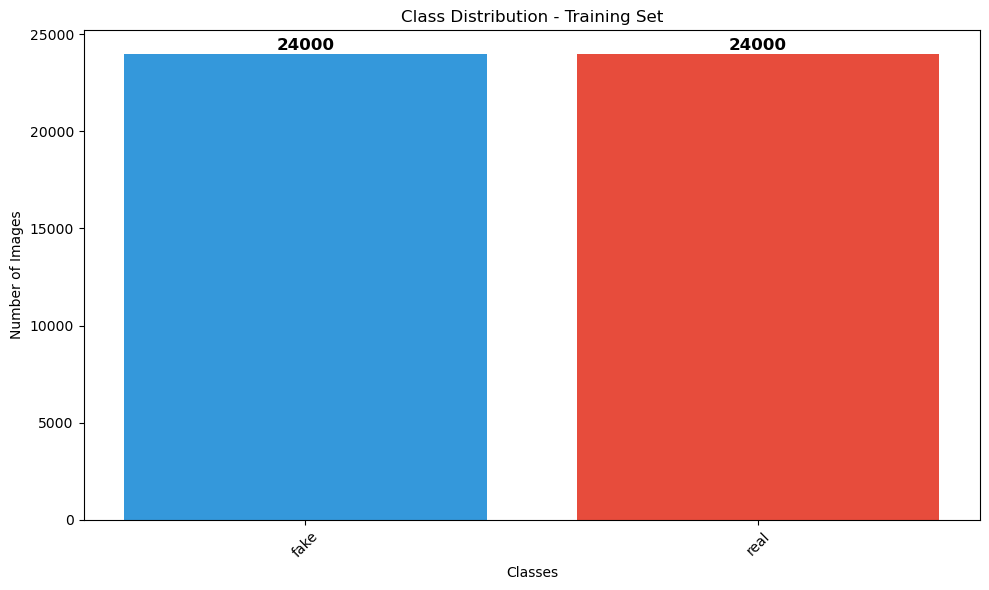


Test Set
--------------------------------------------------
Class 'fake': 6000 images
Class 'real': 6000 images


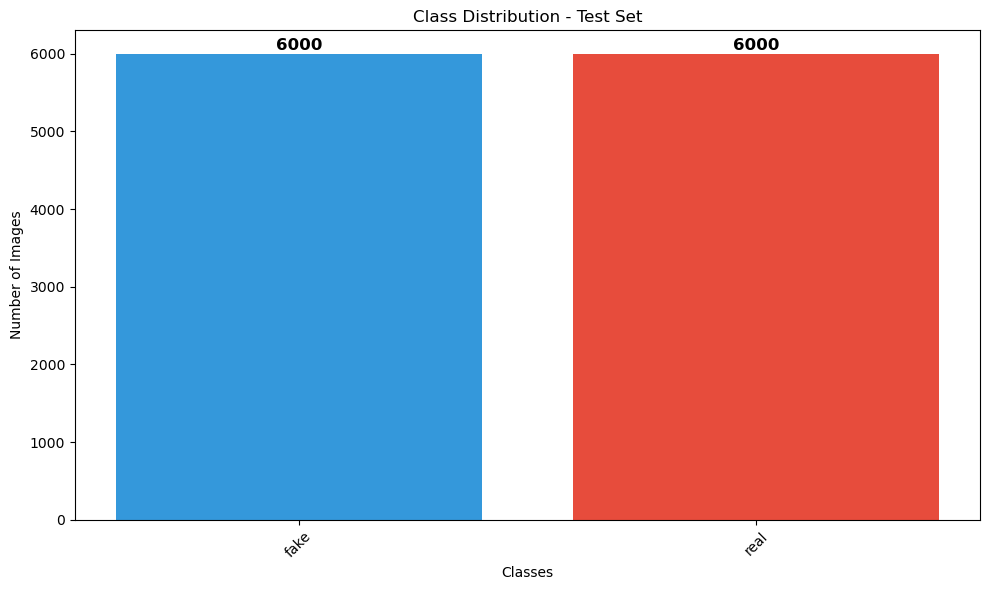

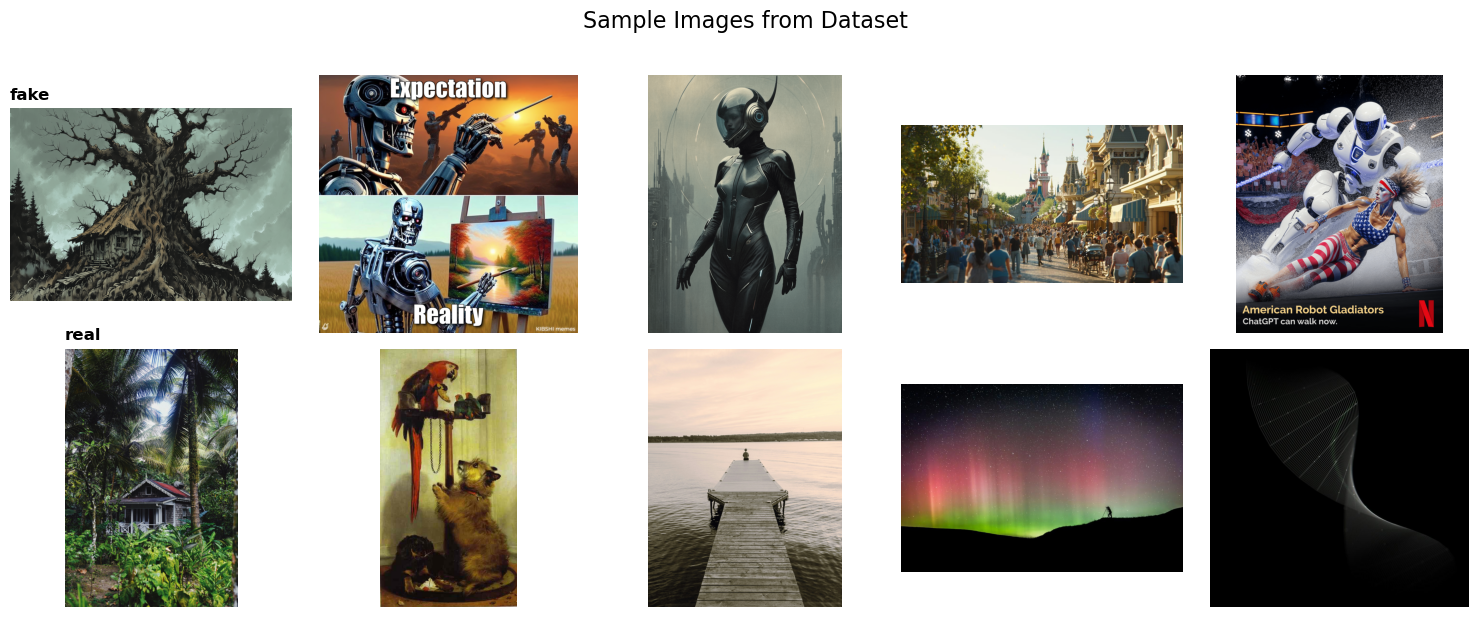

In [8]:
class DatasetAnalyzer:
    """Utility class for dataset analysis and visualization"""
    
    @staticmethod
    def analyze_distribution(
        data_dir: str,
        title: str = "Dataset Distribution"
    ) -> Tuple[List[str], Dict[str, int]]:
        """Analyze and visualize class distribution"""
        print(f"\n{title}")
        print("-" * 50)
        
        classes = sorted(os.listdir(data_dir))
        class_counts = {}
        
        for cls in classes:
            class_path = Path(data_dir) / cls
            if class_path.is_dir():
                count = len([
                    f for f in os.listdir(class_path)
                    if f.lower().endswith(('.png', '.jpg', '.jpeg'))
                ])
                class_counts[cls] = count
                print(f"Class '{cls}': {count} images")
        
        plt.figure(figsize=(10, 6))
        plt.bar(class_counts.keys(), class_counts.values(), color=['#3498db', '#e74c3c'])
        plt.title(f'Class Distribution - {title}')
        plt.xlabel('Classes')
        plt.ylabel('Number of Images')
        plt.xticks(rotation=45)
        
        for i, (cls, count) in enumerate(class_counts.items()):
            plt.text(i, count + 10, str(count), ha='center', va='bottom',
                    fontsize=12, fontweight='bold')
        
        plt.tight_layout()
        plt.show()
        
        return classes, class_counts
    
    @staticmethod
    def visualize_samples(
        data_dir: str,
        classes: List[str],
        samples_per_class: int = 5
    ) -> None:
        """Display sample images from each class"""
        fig, axes = plt.subplots(
            len(classes), samples_per_class,
            figsize=(15, 3 * len(classes))
        )
        fig.suptitle('Sample Images from Dataset', fontsize=16, y=1.02)
        
        for i, cls in enumerate(classes):
            class_path = Path(data_dir) / cls
            images = [
                f for f in os.listdir(class_path)
                if f.lower().endswith(('.png', '.jpg', '.jpeg'))
            ][:samples_per_class]
            
            for j, img_name in enumerate(images):
                img_path = class_path / img_name
                img = Image.open(img_path).convert('RGB')
                
                ax = axes[i, j] if len(classes) > 1 else axes[j]
                ax.imshow(img)
                ax.axis('off')
                
                if j == 0:
                    ax.set_title(f'{cls}', fontsize=12, fontweight='bold', loc='left')
        
        plt.tight_layout()
        plt.show()


analyzer = DatasetAnalyzer()

train_classes, train_counts = analyzer.analyze_distribution(
    config.train_dir, "Training Set"
)
test_classes, test_counts = analyzer.analyze_distribution(
    config.test_dir, "Test Set"
)

analyzer.visualize_samples(config.train_dir, train_classes, samples_per_class=5)

## Create data loaders

In [9]:
train_transform, val_transform = get_transforms(config)

full_train_dataset = ImageDataset(
    config.train_dir,
    transform=train_transform
)

test_dataset = ImageDataset(
    config.test_dir,
    transform=val_transform
)

train_size = int(config.train_split * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size

train_dataset, val_dataset = random_split(
    full_train_dataset,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(42)
)

val_dataset.dataset.transform = val_transform

print(f"\nDataset Splits:")
print(f"  Training:   {len(train_dataset):,}")
print(f"  Validation: {len(val_dataset):,}")
print(f"  Test:       {len(test_dataset):,}")
print(f"\nClasses: {test_dataset.classes}")
print(f"Mapping: {test_dataset.class_to_idx}")

train_loader = DataLoader(
    train_dataset,
    batch_size=config.batch_size,
    shuffle=True,
    num_workers=config.num_workers,
    pin_memory=True,
    persistent_workers=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=config.batch_size,
    shuffle=False,
    num_workers=config.num_workers,
    pin_memory=True,
    persistent_workers=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=config.batch_size,
    shuffle=False,
    num_workers=config.num_workers,
    pin_memory=True,
    persistent_workers=True
)

print("\nData loaders created successfully")

Found 48000 images
Classes: ['Real', 'Fake']
Mapping: {'Real': 0, 'Fake': 1}
Found 12000 images
Classes: ['Real', 'Fake']
Mapping: {'Real': 0, 'Fake': 1}

Dataset Splits:
  Training:   38,400
  Validation: 9,600
  Test:       12,000

Classes: ['Real', 'Fake']
Mapping: {'Real': 0, 'Fake': 1}

Data loaders created successfully


## Create the model to train

In [10]:
import timm
import torch
import torch.nn as nn
from typing import Optional


class XceptionClassifier(nn.Module):
    """Xception binary classifier with Grad-CAM support"""
    
    def __init__(self, num_classes: int = 1, pretrained: bool = True) -> None:
        super().__init__()
        
        self.xception = timm.create_model(
            'xception',
            pretrained=pretrained,
            num_classes=0, 
            global_pool='' 
        )
        
        in_features = self.xception.num_features 
        
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Dropout(p=0.3),
            nn.Linear(in_features, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.4),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.3),
            nn.Linear(256, num_classes)
        )
        
        self.gradients: Optional[torch.Tensor] = None
        self.activations: Optional[torch.Tensor] = None
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Standard forward pass"""
        x = self.xception(x)
        x = self.classifier(x)
        return x
    
    def forward_with_cam(self, x: torch.Tensor) -> torch.Tensor:
        """Forward pass with activation storage for Grad-CAM"""
        x = self.xception(x)
        self.activations = x
        
        if x.requires_grad:
            x.register_hook(self._save_gradient)
        
        x = self.classifier(x)
        
        return x
    
    def _save_gradient(self, grad: torch.Tensor) -> None:
        """Hook to save gradients for Grad-CAM"""
        self.gradients = grad


def create_model(config: Config) -> nn.Module:
    """Create and initialize model"""
    model = XceptionClassifier(num_classes=1, pretrained=True)
    
    if torch.cuda.device_count() > 1:
        print(f"Using {torch.cuda.device_count()} GPUs with DataParallel")
        model = nn.DataParallel(model)
    
    model = model.to(config.device)
    
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    print(f"\nModel: Xception (timm)")
    print(f"Total parameters:     {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")
    
    return model


model = create_model(config)


Model: Xception (timm)
Total parameters:     21,989,161
Trainable parameters: 21,989,161


## Create training components

In [ ]:
class EarlyStopping:
    # early stopping to prevent overfitting
    def __init__(
        self,
        patience: int = 3,
        min_delta: float = 0.0,
        verbose: bool = True,
        path: str = 'best_model.pth'
    ) -> None:
        self.patience = patience
        self.min_delta = min_delta
        self.verbose = verbose
        self.path = path
        
        self.counter = 0
        self.best_loss: Optional[float] = None
        self.early_stop = False
        self.best_epoch = 0
    
    def __call__(self, val_loss: float, model: nn.Module, epoch: int) -> None:
        if self.best_loss is None:
            self.best_loss = val_loss
            self._save_checkpoint(model)
            self.best_epoch = epoch
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter}/{self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
                if self.verbose:
                    print(f'Early stopping! Best loss: {self.best_loss:.4f} at epoch {self.best_epoch + 1}')
        else:
            self.best_loss = val_loss
            self._save_checkpoint(model)
            self.counter = 0
            self.best_epoch = epoch
    
    def _save_checkpoint(self, model: nn.Module) -> None:
        if self.verbose:
            print(f'Validation loss improved ({self.best_loss:.4f}). Saving model...')
        torch.save(model.state_dict(), self.path)


class Trainer:
    # handles model training and validation
    
    def __init__(
        self,
        model: nn.Module,
        config: Config,
        train_loader: DataLoader,
        val_loader: DataLoader
    ) -> None:
        self.model = model
        self.config = config
        self.train_loader = train_loader
        self.val_loader = val_loader
        
        self.criterion = nn.BCEWithLogitsLoss()
        self.optimizer = optim.AdamW(
            model.parameters(),
            lr=config.learning_rate,
            weight_decay=config.weight_decay
        )
        self.scheduler = optim.lr_scheduler.CosineAnnealingLR(
            self.optimizer,
            T_max=config.num_epochs,
            eta_min=1e-6
        )
        
        self.history = {
            'train_loss': [],
            'train_acc': [],
            'val_loss': [],
            'val_acc': []
        }
    
    def _train_epoch(self) -> Tuple[float, float]:
        # train for one epoch
        self.model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        pbar = tqdm(self.train_loader, desc='Training', leave=False)
        for inputs, labels in pbar:
            inputs = inputs.to(self.config.device)
            labels = labels.to(self.config.device).float().unsqueeze(1)
            
            self.optimizer.zero_grad()
            outputs = self.model(inputs)
            loss = self.criterion(outputs, labels)
            loss.backward()
            self.optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            predicted = (torch.sigmoid(outputs) > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            pbar.set_postfix({'loss': loss.item(), 'acc': 100. * correct / total})
        
        epoch_loss = running_loss / total
        epoch_acc = correct / total
        return epoch_loss, epoch_acc
    
    def _validate_epoch(self) -> Tuple[float, float]:
        # validate for one epoch
        self.model.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            pbar = tqdm(self.val_loader, desc='Validation', leave=False)
            for inputs, labels in pbar:
                inputs = inputs.to(self.config.device)
                labels = labels.to(self.config.device).float().unsqueeze(1)
                
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                
                running_loss += loss.item() * inputs.size(0)
                predicted = (torch.sigmoid(outputs) > 0.5).float()
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                
                pbar.set_postfix({'loss': loss.item(), 'acc': 100. * correct / total})
        
        epoch_loss = running_loss / total
        epoch_acc = correct / total
        return epoch_loss, epoch_acc
    
    def fit(self, early_stopping: EarlyStopping) -> Dict[str, List[float]]:
        # train model with early stopping
        print(f"\n{'=' * 50}")
        print("Training Started")
        print(f"{'=' * 50}")
        
        for epoch in range(self.config.num_epochs):
            print(f'\nEpoch {epoch + 1}/{self.config.num_epochs}')
            print('-' * 50)
            
            train_loss, train_acc = self._train_epoch()
            val_loss, val_acc = self._validate_epoch()
            
            self.history['train_loss'].append(train_loss)
            self.history['train_acc'].append(train_acc)
            self.history['val_loss'].append(val_loss)
            self.history['val_acc'].append(val_acc)
            
            print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc * 100:.2f}%')
            print(f'Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc * 100:.2f}%')
            
            self.scheduler.step()
            early_stopping(val_loss, self.model, epoch)
            
            if early_stopping.early_stop:
                print(f"\n{'=' * 50}")
                print(f"Early stopping at epoch {epoch + 1}")
                print(f"Best val loss: {early_stopping.best_loss:.4f} at epoch {early_stopping.best_epoch + 1}")
                print(f"{'=' * 50}")
                break
        
        print(f"\nTraining completed!")
        print(f"Best validation loss: {early_stopping.best_loss:.4f} (epoch {early_stopping.best_epoch + 1})")
        
        return self.history

print("Training components defined successfully")

Training components defined successfully


## Train model

In [12]:
early_stopping = EarlyStopping(
    patience=config.patience,
    min_delta=config.min_delta,
    verbose=True,
    path=str(Path(config.output_dir) / 'best_efficientnet_model.pth')
)

trainer = Trainer(
    model=model,
    config=config,
    train_loader=train_loader,
    val_loader=val_loader
)

history = trainer.fit(early_stopping)


Training Started

Epoch 1/10
--------------------------------------------------


Train Loss: 0.2706 | Train Acc: 88.77%
Val Loss:   0.1782 | Val Acc:   93.46%
Validation loss improved (0.1782). Saving model...

Epoch 2/10
--------------------------------------------------


Train Loss: 0.1265 | Train Acc: 95.58%
Val Loss:   0.1517 | Val Acc:   94.46%
Validation loss improved (0.1517). Saving model...

Epoch 3/10
--------------------------------------------------


Train Loss: 0.0710 | Train Acc: 97.61%
Val Loss:   0.1650 | Val Acc:   94.11%
EarlyStopping counter: 1/5

Epoch 4/10
--------------------------------------------------


Train Loss: 0.0439 | Train Acc: 98.44%
Val Loss:   0.1610 | Val Acc:   94.58%
EarlyStopping counter: 2/5

Epoch 5/10
--------------------------------------------------


Train Loss: 0.0278 | Train Acc: 99.06%
Val Loss:   0.2001 | Val Acc:   94.09%
EarlyStopping counter: 3/5

Epoch 6/10
--------------------------------------------------


Train Loss: 0.0164 | Train Acc: 99.44%
Val Loss:   0.1635 | Val Acc:   94.74%
EarlyStopping counter: 4/5

Epoch 7/10
--------------------------------------------------


Train Loss: 0.0094 | Train Acc: 99.70%
Val Loss:   0.1558 | Val Acc:   95.03%
EarlyStopping counter: 5/5
Early stopping! Best loss: 0.1517 at epoch 2

Early stopping at epoch 7
Best val loss: 0.1517 at epoch 2

Training completed!
Best validation loss: 0.1517 (epoch 2)


## Load model code

In [13]:
import torch
from pathlib import Path

model_path = Path(config.output_dir) / 'best_efficientnet_model.pth'
checkpoint = torch.load(model_path, map_location=config.device)
model.load_state_dict(checkpoint)

model.eval()

XceptionClassifier(
  (xception): Xception(
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act2): ReLU(inplace=True)
    (block1): Block(
      (skip): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (skipbn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (rep): Sequential(
        (0): SeparableConv2d(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
          (pointwise): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        )
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Re

## Model evaluation

In [14]:
class ModelEvaluator:
    # evaluate model and compute metrics
    
    def __init__(self, model: nn.Module, config: Config) -> None:
        self.model = model
        self.config = config
    
    def evaluate(
        self,
        test_loader: DataLoader
    ) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
        # evaluate model on test set
        self.model.eval()
        
        y_true = []
        y_pred = []
        y_scores = []
        
        with torch.no_grad():
            for inputs, labels in tqdm(test_loader, desc='Testing'):
                inputs = inputs.to(self.config.device)
                outputs = self.model(inputs)
                probs = torch.sigmoid(outputs).cpu().numpy()
                preds = (probs > 0.5).astype(int)
                
                y_true.extend(labels.numpy())
                y_pred.extend(preds.flatten())
                y_scores.extend(probs.flatten())
        
        return np.array(y_true), np.array(y_pred), np.array(y_scores)
    
    @staticmethod
    def compute_metrics(
        y_true: np.ndarray,
        y_pred: np.ndarray,
        y_scores: np.ndarray
    ) -> Dict[str, float]:
        # compute classification metrics
        metrics = {
            'accuracy': (y_true == y_pred).mean(),
            'precision': precision_score(y_true, y_pred),
            'recall': recall_score(y_true, y_pred),
            'f1': f1_score(y_true, y_pred),
            'roc_auc': roc_auc_score(y_true, y_scores),
            'pr_auc': average_precision_score(y_true, y_scores)
        }
        return metrics
    
    @staticmethod
    def print_metrics(metrics: Dict[str, float]) -> None:
        # print metrics in a formatted way
        print(f"\n{'=' * 50}")
        print("Classification Metrics")
        print(f"{'=' * 50}")
        print(f"Accuracy:  {metrics['accuracy'] * 100:.2f}%")
        print(f"Precision: {metrics['precision']:.4f}")
        print(f"Recall:    {metrics['recall']:.4f}")
        print(f"F1-Score:  {metrics['f1']:.4f}")
        print(f"ROC AUC:   {metrics['roc_auc']:.4f}")
        print(f"PR AUC:    {metrics['pr_auc']:.4f}")


model.load_state_dict(torch.load(
    str(Path(config.output_dir) / 'best_efficientnet_model.pth')
))

evaluator = ModelEvaluator(model, config)
y_true, y_pred, y_scores = evaluator.evaluate(test_loader)

metrics = evaluator.compute_metrics(y_true, y_pred, y_scores)
evaluator.print_metrics(metrics)

print(f"\n{'-' * 50}")
print("Classification Report")
print(f"{'-' * 50}")
print(classification_report(y_true, y_pred, target_names=['Real', 'Fake']))

Testing: 100%|██████████| 750/750 [04:22<00:00,  2.86it/s]


Classification Metrics
Accuracy:  94.57%
Precision: 0.9517
Recall:    0.9390
F1-Score:  0.9453
ROC AUC:   0.9871
PR AUC:    0.9880

--------------------------------------------------
Classification Report
--------------------------------------------------
              precision    recall  f1-score   support

        Real       0.94      0.95      0.95      6000
        Fake       0.95      0.94      0.95      6000

    accuracy                           0.95     12000
   macro avg       0.95      0.95      0.95     12000
weighted avg       0.95      0.95      0.95     12000



## GradCAM heatmaps setup

In [15]:
class GradCAM:
    # generate GradCAM heatmaps
    
    def __init__(self, model: nn.Module) -> None:
        self.model = model
        self.model.eval()
    
    def generate_cam(
        self,
        input_tensor: torch.Tensor,
        target_class: Optional[int] = None
    ) -> np.ndarray:
        # generate GradCAM heatmap, [H,W]
        score = self.model.forward_with_cam(input_tensor)
        
        if target_class is None:
            target_class = torch.sigmoid(score).round().long().item()
        
        output = score if int(target_class) == 1 else -score
        
        self.model.zero_grad()
        output.backward(retain_graph=True)
        
        gradients = self.model.gradients  # [1, C, H, W]
        activations = self.model.activations  # [1, C, H, W]
        
        weights = torch.mean(gradients, dim=(2, 3), keepdim=True)  # [1, C, 1, 1]
        cam = torch.sum(weights * activations, dim=1).squeeze()  # [H, W]
        cam = torch.relu(cam)
        
        cam = cam - cam.min()
        cam = cam / (cam.max() + 1e-8)
        
        return cam.detach().cpu().numpy()


class GradCAMVisualizer:
    # visualize GradCAM heatmaps
    
    @staticmethod
    def apply_colormap(
        org_img: Image.Image,
        activation_map: np.ndarray,
        colormap: int = cv2.COLORMAP_JET
    ) -> Tuple[np.ndarray, np.ndarray]:
        # apply heatmap overlay on original image
        if isinstance(org_img, Image.Image):
            org_img = np.array(org_img)
        
        heatmap = cv2.resize(activation_map, (org_img.shape[1], org_img.shape[0]))
        heatmap = np.uint8(255 * heatmap)
        heatmap = cv2.applyColorMap(heatmap, colormap)
        heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
        
        overlayed = cv2.addWeighted(org_img, 0.6, heatmap, 0.4, 0)
        
        return heatmap, overlayed
    
    @staticmethod
    def visualize_single(
        model: nn.Module,
        image_tensor: torch.Tensor,
        original_image: Image.Image,
        device: torch.device,
        save_path: Optional[str] = None
    ) -> None:
        # visualize GradCAM for a single image
        net = model.module if isinstance(model, nn.DataParallel) else model
        net.eval()
        
        image_tensor = image_tensor.unsqueeze(0).to(device)
        image_tensor.requires_grad = True
        
        grad_cam = GradCAM(net)
        cam = grad_cam.generate_cam(image_tensor)
        
        with torch.no_grad():
            output = net(image_tensor)
            prediction = torch.sigmoid(output).item()
        
        heatmap, overlayed = GradCAMVisualizer.apply_colormap(original_image, cam)
        
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        
        axes[0].imshow(original_image)
        axes[0].set_title('Original Image', fontsize=12, fontweight='bold')
        axes[0].axis('off')
        
        axes[1].imshow(heatmap)
        axes[1].set_title('Grad-CAM Heatmap', fontsize=12, fontweight='bold')
        axes[1].axis('off')
        
        pred_class = "Fake" if prediction > 0.5 else "Real"
        axes[2].imshow(overlayed)
        axes[2].set_title(
            f'Grad-CAM Overlay\nPrediction: {pred_class} ({prediction:.3f})',
            fontsize=12, fontweight='bold'
        )
        axes[2].axis('off')
        
        plt.tight_layout()
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()
    
    @staticmethod
    def visualize_multiple(
        model: nn.Module,
        test_dataset: ImageDataset,
        transform: transforms.Compose,
        device: torch.device,
        num_samples: int = 6,
        save_path: Optional[str] = None
    ) -> None:
        # visualize GradCAM for multiple test images
        net = model.module if isinstance(model, nn.DataParallel) else model
        net.eval()
        
        indices = np.random.choice(len(test_dataset), num_samples, replace=False)
        
        fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5 * num_samples))
        fig.suptitle(
            'Grad-CAM Visualization on Test Images',
            fontsize=16, fontweight='bold', y=0.995
        )
        
        grad_cam = GradCAM(net)
        
        for idx, test_idx in enumerate(indices):
            img_path, true_label_idx = test_dataset.samples[test_idx]
            original_img = Image.open(img_path).convert('RGB')
            img_tensor = transform(original_img)
            
            img_tensor_batch = img_tensor.unsqueeze(0).to(device)
            img_tensor_batch.requires_grad = True
            
            cam = grad_cam.generate_cam(img_tensor_batch)
            
            with torch.no_grad():
                output = net(img_tensor_batch)
                prediction = torch.sigmoid(output).item()
            
            heatmap, overlayed = GradCAMVisualizer.apply_colormap(original_img, cam)
            
            axes[idx, 0].imshow(original_img)
            axes[idx, 0].set_title(f'Image {idx + 1}', fontsize=10, fontweight='bold')
            axes[idx, 0].axis('off')
            
            axes[idx, 1].imshow(heatmap)
            axes[idx, 1].set_title('Grad-CAM Heatmap', fontsize=10, fontweight='bold')
            axes[idx, 1].axis('off')
            
            true_label = test_dataset.classes[true_label_idx]
            pred_class = "Fake" if prediction > 0.5 else "Real"
            axes[idx, 2].imshow(overlayed)
            axes[idx, 2].set_title(
                f'Overlay | True: {true_label}\nPrediction: {pred_class} ({prediction:.3f})',
                fontsize=10, fontweight='bold'
            )
            axes[idx, 2].axis('off')
        
        plt.tight_layout()
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()

print("Grad-CAM components defined successfully")

Grad-CAM components defined successfully


## Visualize results

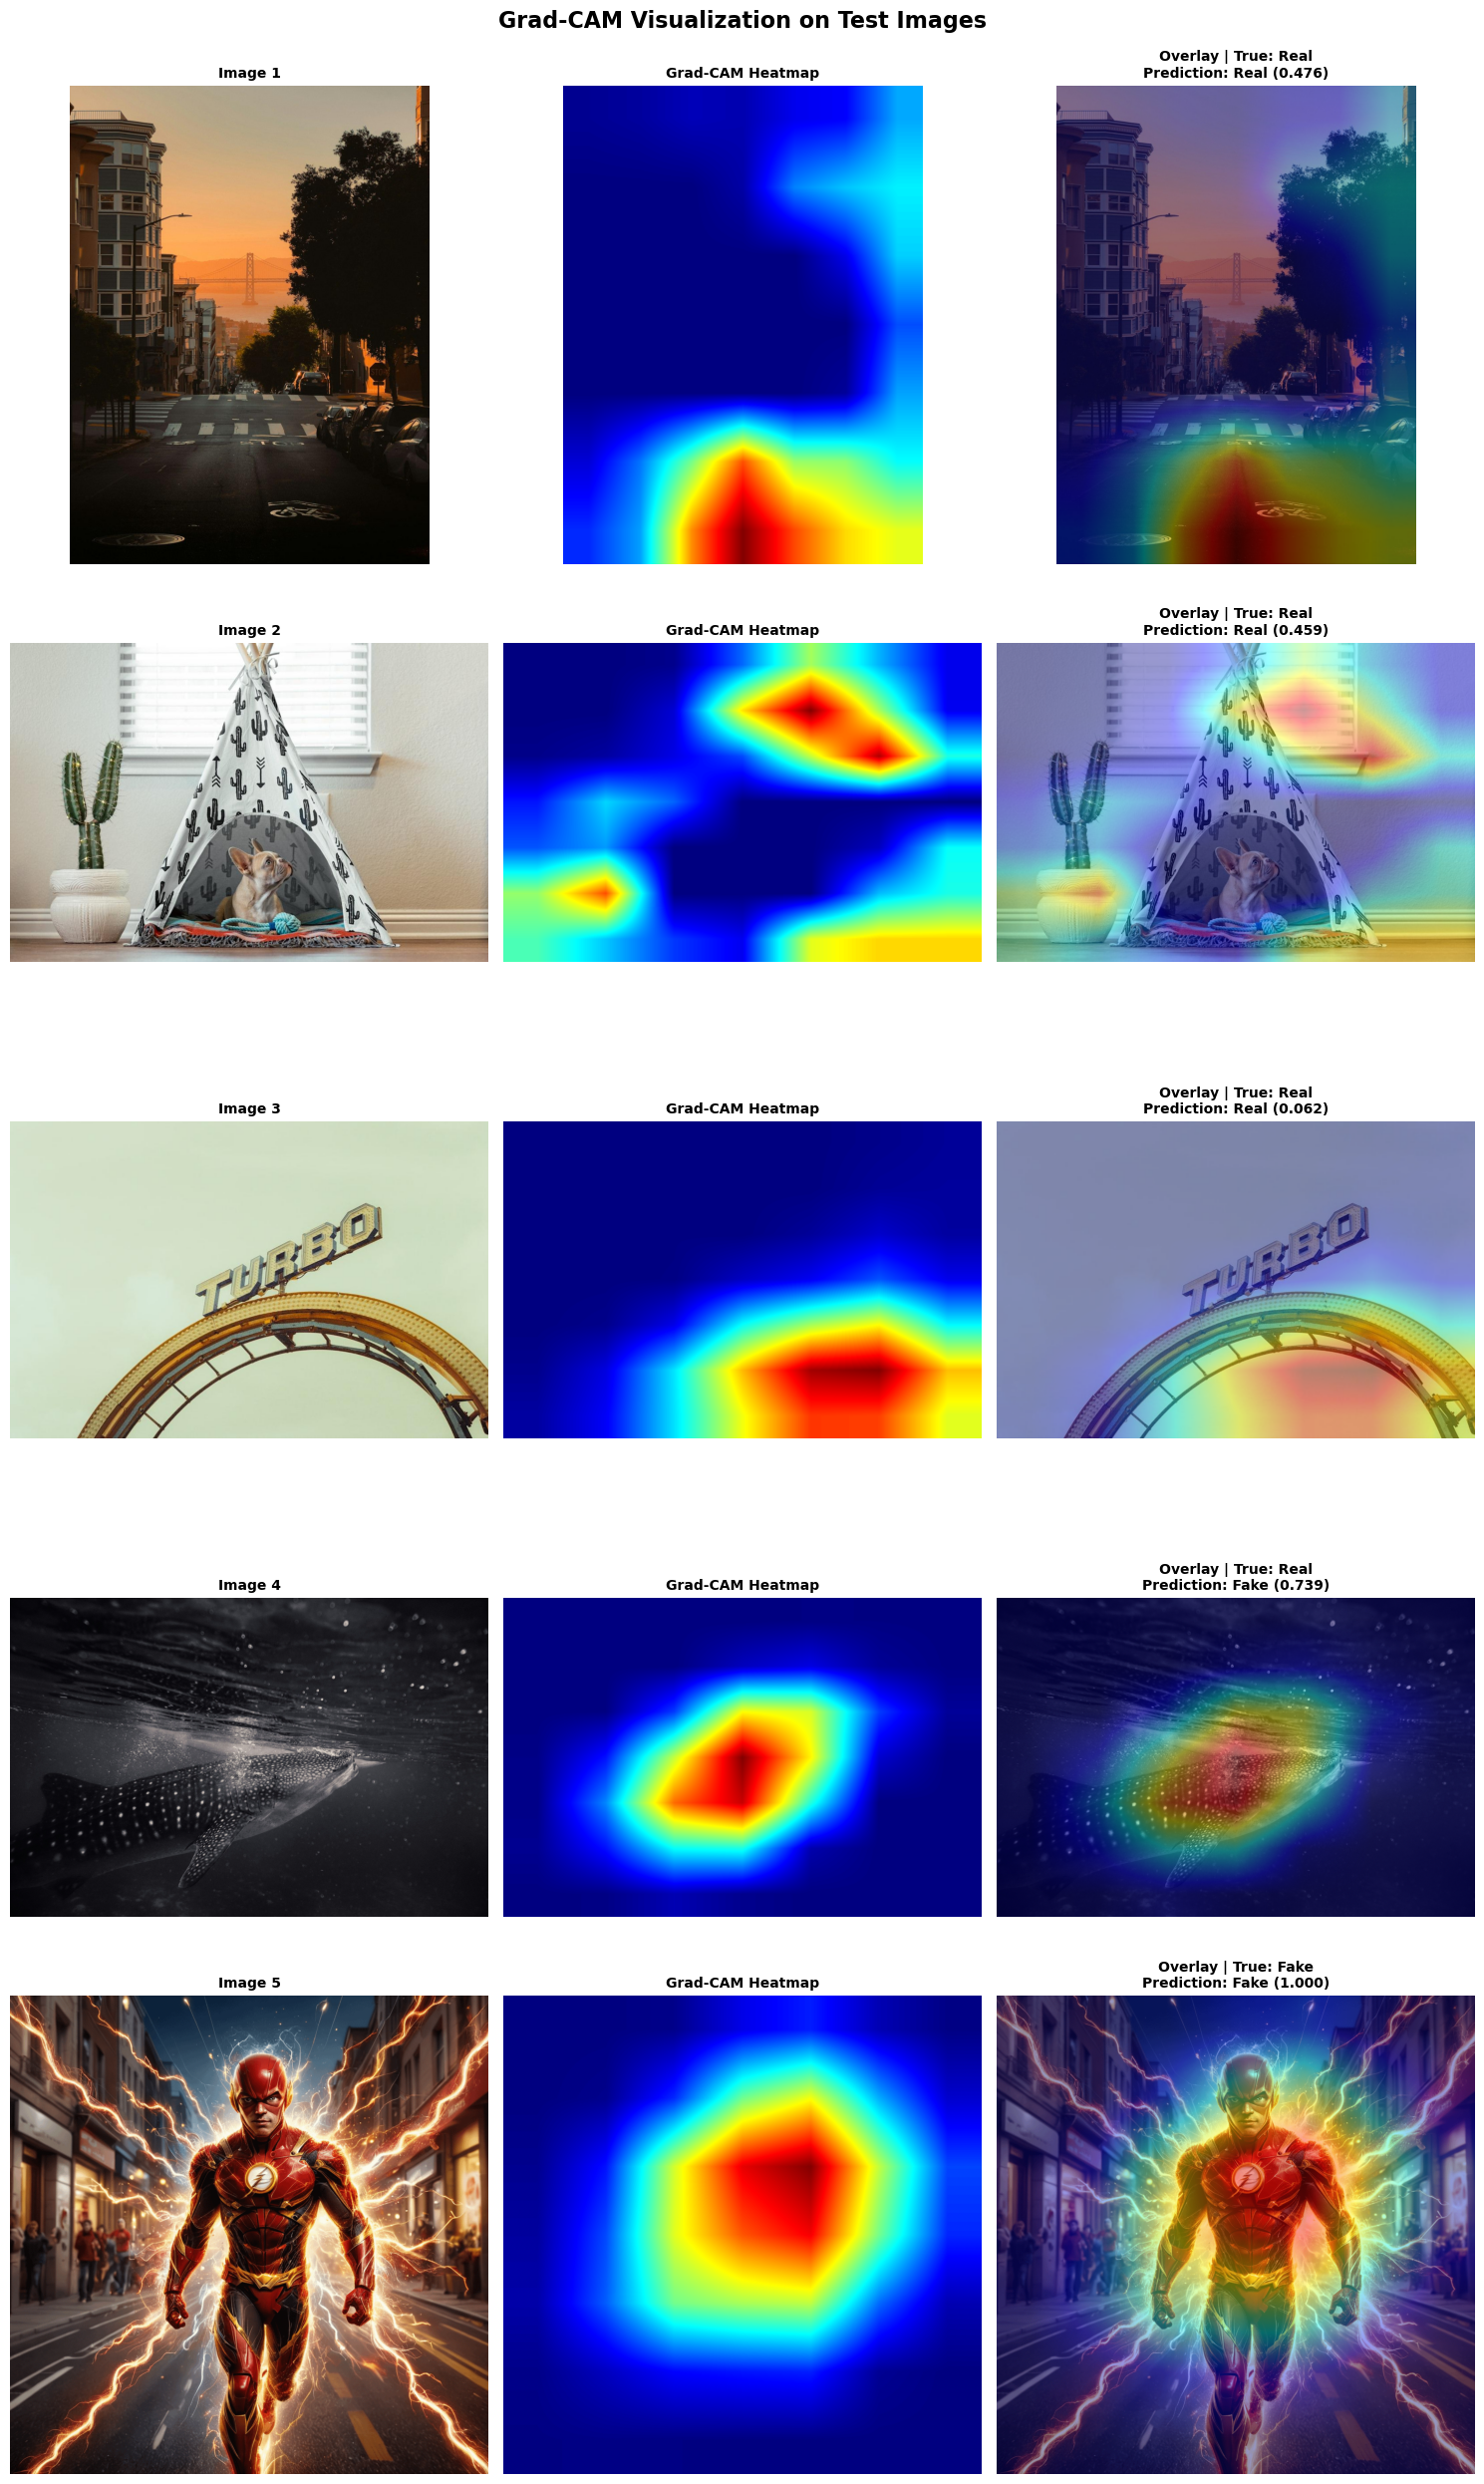

In [16]:
visualizer = GradCAMVisualizer()

visualizer.visualize_multiple(
    model=model,
    test_dataset=test_dataset,
    transform=val_transform,
    device=config.device,
    num_samples=5,
    save_path=str(Path(config.output_dir) / 'gradcam_visualization_multiple.png')
)

Loaded custom dataset with 78 images.
Class mapping: {'FAKE': 0, 'REAL': 1}

Calculating accuracy on 'our_test'...
Accuracy on Custom Dataset: 52.56%

Generating GradCAM visualizations...


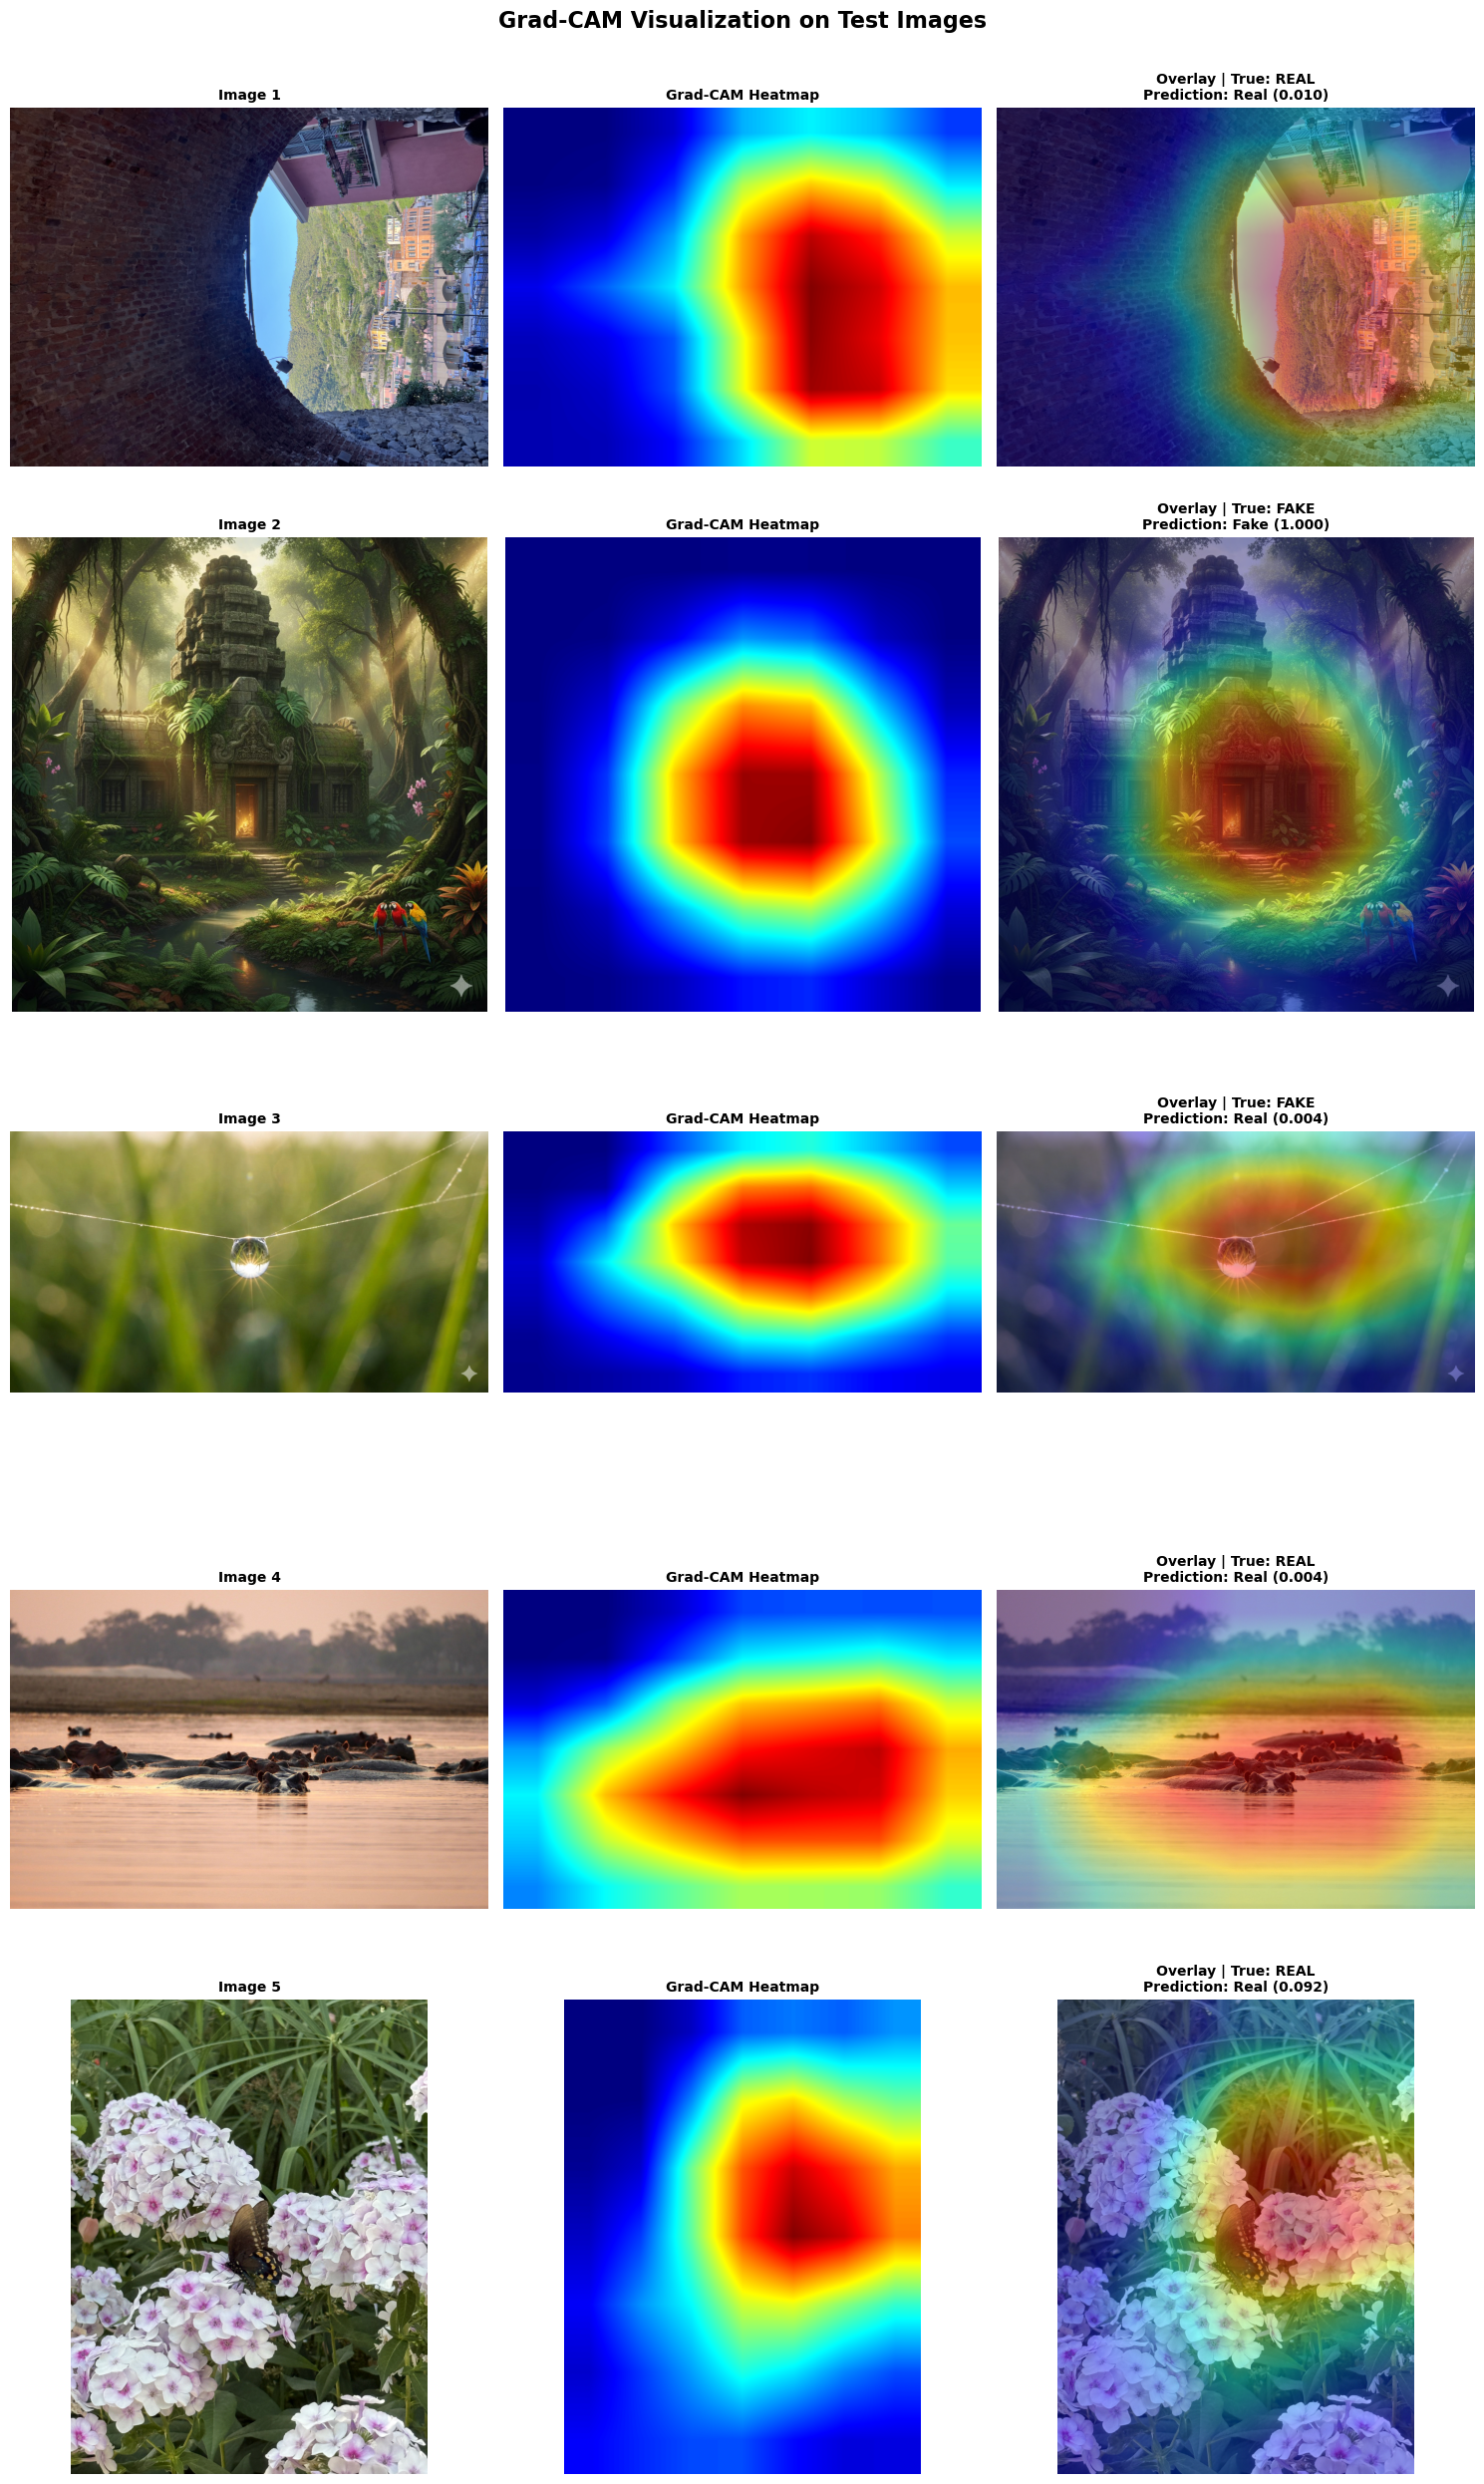

Done! Visualization saved to data/working/gradcam_visualization_our_test.png


In [20]:
import torch
from torchvision import datasets
from torch.utils.data import DataLoader
from pathlib import Path

# 1. Load the Custom Dataset (our_test)
# Assumes folder structure: our_test/real and our_test/fake
custom_data_path = 'our_test'

custom_test_dataset = datasets.ImageFolder(
    root=custom_data_path,
    transform=val_transform  # Using the same transform as validation
)

print(f"Loaded custom dataset with {len(custom_test_dataset)} images.")
print(f"Class mapping: {custom_test_dataset.class_to_idx}")

# 2. Define function to check Accuracy
def evaluate_accuracy(model, dataset, device, batch_size=32):
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    model.eval()
    
    correct = 0
    total = 0
    
    print(f"\nCalculating accuracy on '{custom_data_path}'...")
    
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    acc = 100 * correct / total
    print(f'Accuracy on Custom Dataset: {acc:.2f}%')
    return acc

# 3. Run Evaluation
evaluate_accuracy(model, custom_test_dataset, config.device, config.batch_size)

# 4. Run GradCAM Visualization
print("\nGenerating GradCAM visualizations...")
visualizer = GradCAMVisualizer()

visualizer.visualize_multiple(
    model=model,
    test_dataset=custom_test_dataset,  # Passing the 'our_test' dataset here
    transform=val_transform,
    device=config.device,
    num_samples=5,
    save_path=str(Path(config.output_dir) / 'gradcam_visualization_our_test.png')
)

print(f"Done! Visualization saved to {Path(config.output_dir) / 'gradcam_visualization_our_test.png'}")

Loaded dataset: 78 images.
Running inference on custom dataset...

Results:
Accuracy: 76.92%
ROC AUC:  0.8293
PR AUC:   0.7937


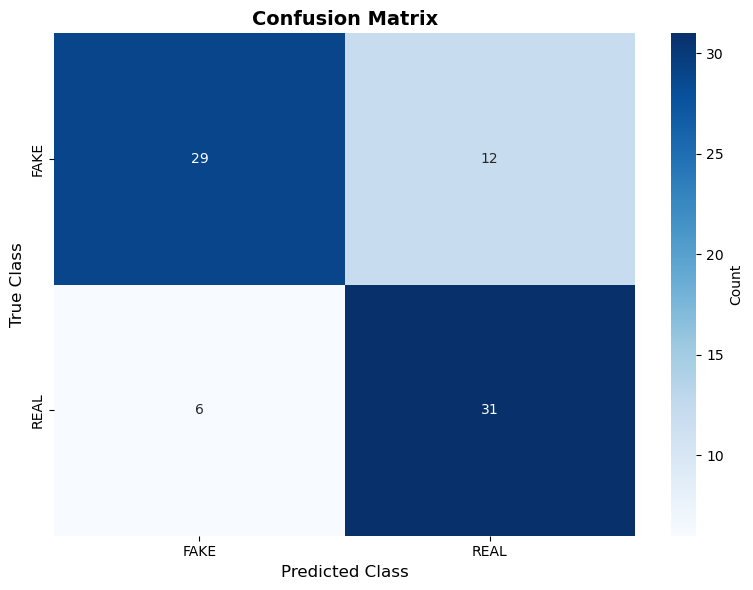

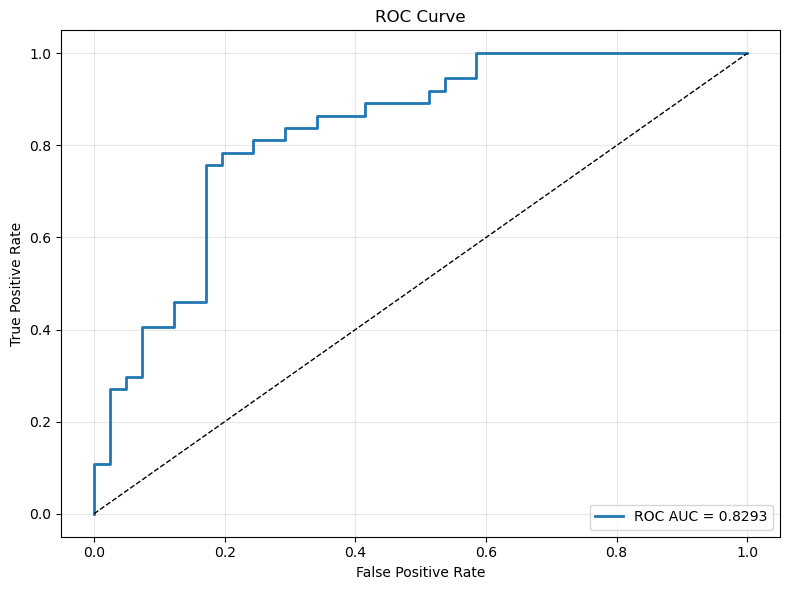

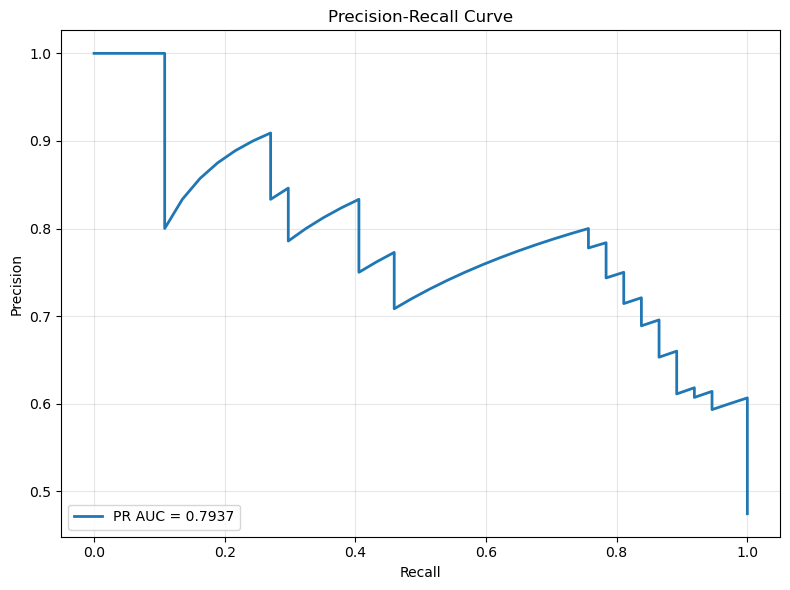


Analysis Complete. Outputs saved to data/working


In [24]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve, accuracy_score, roc_auc_score, average_precision_score
from typing import Dict, List, Optional
from pathlib import Path

# --- 1. SETUP THE DATA ---
custom_data_path = 'our_test'
test_dataset = datasets.ImageFolder(
    root=custom_data_path,
    transform=val_transform 
)
test_loader = DataLoader(test_dataset, batch_size=config.batch_size, shuffle=False)

print(f"Loaded dataset: {len(test_dataset)} images.")
# Standard ImageFolder mapping is typically {'FAKE': 0, 'REAL': 1}

# --- 2. VISUALIZER CLASS ---
class ResultVisualizer:
    @staticmethod
    def plot_confusion_matrix(y_true, y_pred, class_names, save_path=None):
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=class_names, yticklabels=class_names,
                    cbar_kws={'label': 'Count'})
        plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
        plt.xlabel('Predicted Class', fontsize=12)
        plt.ylabel('True Class', fontsize=12)
        plt.tight_layout()
        if save_path: plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()

    @staticmethod
    def plot_roc_curve(y_true, y_scores, roc_auc, save_path=None):
        fpr, tpr, _ = roc_curve(y_true, y_scores)
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, linewidth=2, label=f'ROC AUC = {roc_auc:.4f}')
        plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
        plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
        plt.title('ROC Curve'); plt.legend(loc="lower right")
        plt.grid(True, alpha=0.3); plt.tight_layout()
        if save_path: plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()

    @staticmethod
    def plot_precision_recall_curve(y_true, y_scores, pr_auc, save_path=None):
        precision, recall, _ = precision_recall_curve(y_true, y_scores)
        plt.figure(figsize=(8, 6))
        plt.plot(recall, precision, linewidth=2, label=f'PR AUC = {pr_auc:.4f}')
        plt.xlabel('Recall'); plt.ylabel('Precision')
        plt.title('Precision-Recall Curve'); plt.legend(loc="lower left")
        plt.grid(True, alpha=0.3); plt.tight_layout()
        if save_path: plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()

# --- 3. GET RAW PREDICTIONS ---
def get_predictions(model, loader, device):
    model.eval()
    y_true = []
    y_pred = []
    y_scores = [] 

    print("Running inference on custom dataset...")
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            outputs = model(images)
            
            # Binary Case (1 output neuron)
            if outputs.shape[1] == 1:
                probs = torch.sigmoid(outputs)
                predicted = (probs > 0.5).float()
                batch_scores = probs.cpu().numpy().flatten()
            # Multiclass Case
            else:
                probs = F.softmax(outputs, dim=1)
                _, predicted = torch.max(outputs, 1)
                batch_scores = probs[:, 1].cpu().numpy()

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy().flatten())
            y_scores.extend(batch_scores)

    return np.array(y_true), np.array(y_pred), np.array(y_scores)

y_true, y_pred, y_scores = get_predictions(model, test_loader, config.device)

# --- 4. APPLY HARDCODED INVERSION ---
# Automatically flipping predictions (0->1, 1->0) to match dataset mapping
y_pred = 1 - y_pred
y_scores = 1 - y_scores

# --- 5. CALCULATE FINAL METRICS ---
accuracy = accuracy_score(y_true, y_pred)
roc_auc = roc_auc_score(y_true, y_scores)
pr_auc = average_precision_score(y_true, y_scores)

metrics = {'accuracy': accuracy, 'roc_auc': roc_auc, 'pr_auc': pr_auc}

print(f"\nResults:")
print(f"Accuracy: {accuracy*100:.2f}%")
print(f"ROC AUC:  {roc_auc:.4f}")
print(f"PR AUC:   {pr_auc:.4f}")

# --- 6. VISUALIZE ---
viz = ResultVisualizer()
output_dir = Path(config.output_dir)

# We use the standard dataset classes ['Fake', 'Real'] because we aligned the predictions 
# to match this ground truth order.
viz.plot_confusion_matrix(
    y_true, y_pred,
    class_names=test_dataset.classes,
    save_path=str(output_dir / 'confusion_matrix_our_test.png')
)

viz.plot_roc_curve(
    y_true, y_scores, metrics['roc_auc'],
    save_path=str(output_dir / 'roc_curve_our_test.png')
)

viz.plot_precision_recall_curve(
    y_true, y_scores, metrics['pr_auc'],
    save_path=str(output_dir / 'precision_recall_curve_our_test.png')
)

print(f"\nAnalysis Complete. Outputs saved to {config.output_dir}")

## Model analytics

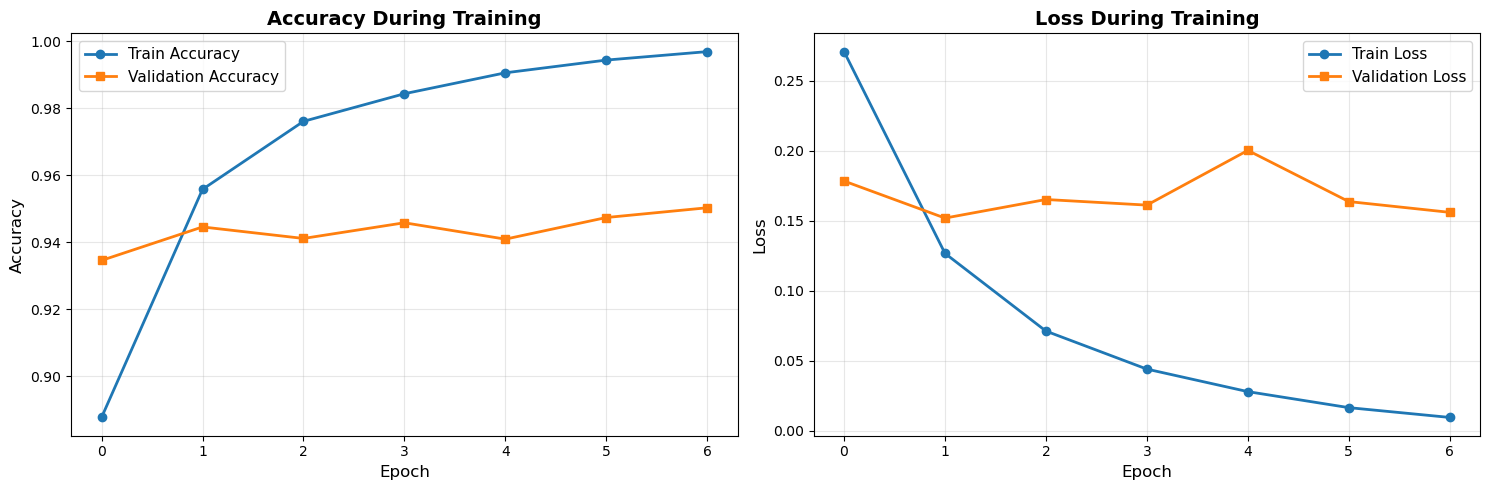

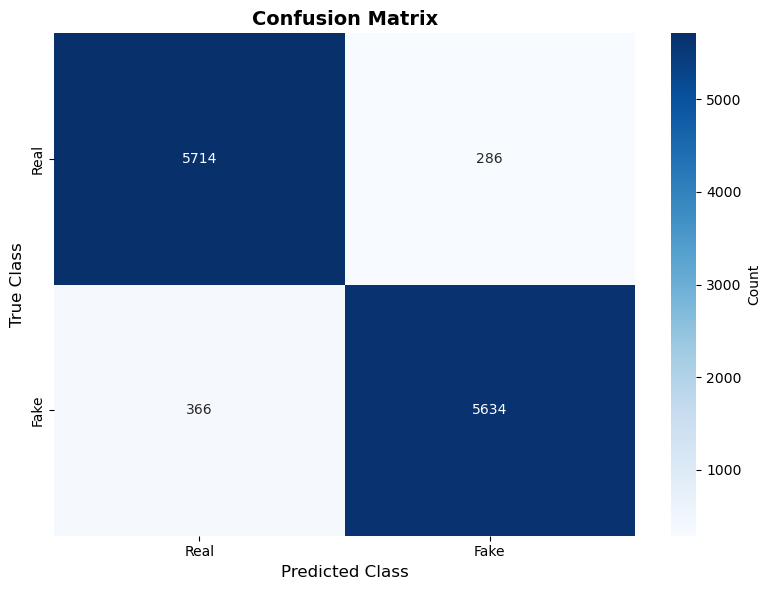

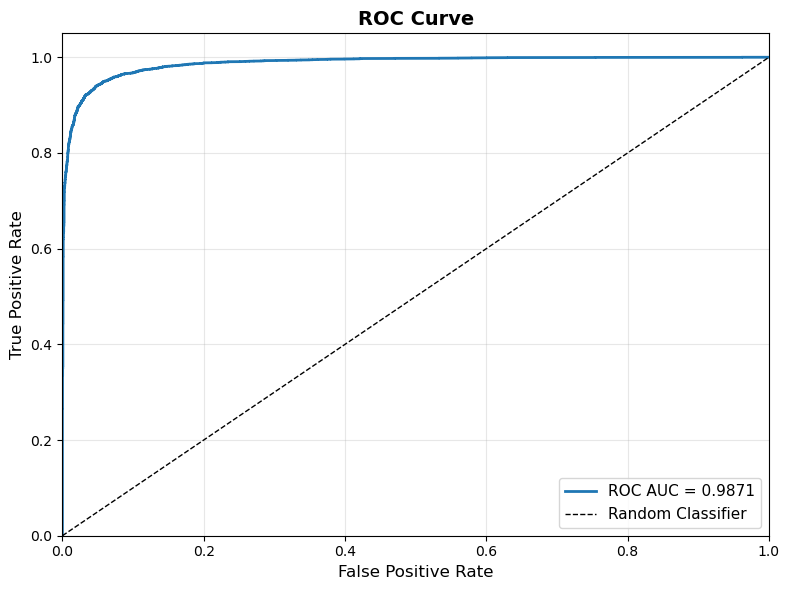

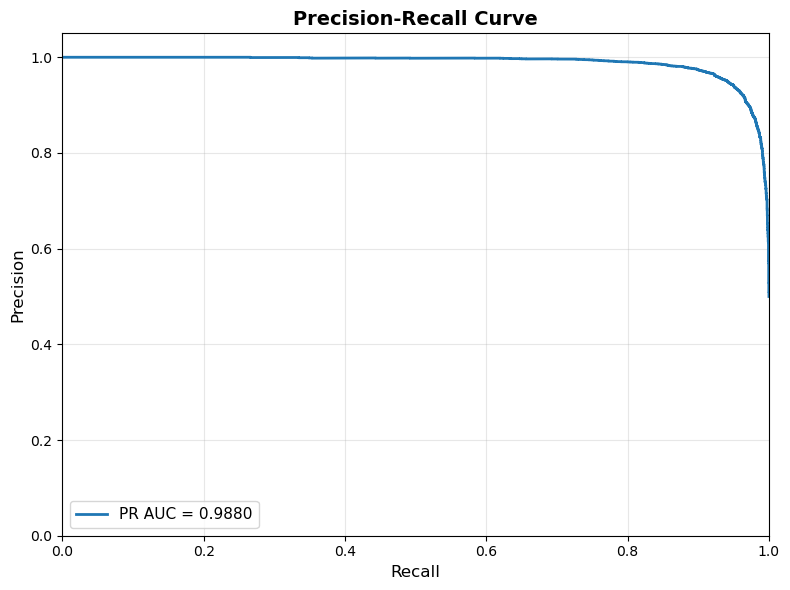


Analysis Complete!

All outputs saved to: data/working


In [19]:
class ResultVisualizer:
    """Visualize training results and evaluation metrics"""
    
    @staticmethod
    def plot_training_curves(
        history: Dict[str, List[float]],
        save_path: Optional[str] = None
    ) -> None:
        """Plot training and validation curves"""
        fig, axes = plt.subplots(1, 2, figsize=(15, 5))
        
        axes[0].plot(history['train_acc'], label='Train Accuracy',
                    linewidth=2, marker='o')
        axes[0].plot(history['val_acc'], label='Validation Accuracy',
                    linewidth=2, marker='s')
        axes[0].set_title('Accuracy During Training', fontsize=14, fontweight='bold')
        axes[0].set_xlabel('Epoch', fontsize=12)
        axes[0].set_ylabel('Accuracy', fontsize=12)
        axes[0].legend(fontsize=11)
        axes[0].grid(True, alpha=0.3)
        
        axes[1].plot(history['train_loss'], label='Train Loss',
                    linewidth=2, marker='o')
        axes[1].plot(history['val_loss'], label='Validation Loss',
                    linewidth=2, marker='s')
        axes[1].set_title('Loss During Training', fontsize=14, fontweight='bold')
        axes[1].set_xlabel('Epoch', fontsize=12)
        axes[1].set_ylabel('Loss', fontsize=12)
        axes[1].legend(fontsize=11)
        axes[1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()
    
    @staticmethod
    def plot_confusion_matrix(
        y_true: np.ndarray,
        y_pred: np.ndarray,
        class_names: List[str] = ['Real', 'Fake'],
        save_path: Optional[str] = None
    ) -> None:
        """Plot confusion matrix"""
        cm = confusion_matrix(y_true, y_pred)
        
        plt.figure(figsize=(8, 6))
        sns.heatmap(
            cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names,
            cbar_kws={'label': 'Count'}
        )
        plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
        plt.xlabel('Predicted Class', fontsize=12)
        plt.ylabel('True Class', fontsize=12)
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()
    
    @staticmethod
    def plot_roc_curve(
        y_true: np.ndarray,
        y_scores: np.ndarray,
        roc_auc: float,
        save_path: Optional[str] = None
    ) -> None:
        """Plot ROC curve"""
        fpr, tpr, _ = roc_curve(y_true, y_scores)
        
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, linewidth=2, label=f'ROC AUC = {roc_auc:.4f}')
        plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate', fontsize=12)
        plt.ylabel('True Positive Rate', fontsize=12)
        plt.title('ROC Curve', fontsize=14, fontweight='bold')
        plt.legend(loc="lower right", fontsize=11)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()
    
    @staticmethod
    def plot_precision_recall_curve(
        y_true: np.ndarray,
        y_scores: np.ndarray,
        pr_auc: float,
        save_path: Optional[str] = None
    ) -> None:
        """Plot Precision-Recall curve"""
        precision, recall, _ = precision_recall_curve(y_true, y_scores)
        
        plt.figure(figsize=(8, 6))
        plt.plot(recall, precision, linewidth=2, label=f'PR AUC = {pr_auc:.4f}')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('Recall', fontsize=12)
        plt.ylabel('Precision', fontsize=12)
        plt.title('Precision-Recall Curve', fontsize=14, fontweight='bold')
        plt.legend(loc="lower left", fontsize=11)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()


viz = ResultVisualizer()

viz.plot_training_curves(
    history,
    save_path=str(Path(config.output_dir) / 'training_curves.png')
)

viz.plot_confusion_matrix(
    y_true, y_pred,
    save_path=str(Path(config.output_dir) / 'confusion_matrix.png')
)

viz.plot_roc_curve(
    y_true, y_scores, metrics['roc_auc'],
    save_path=str(Path(config.output_dir) / 'roc_curve.png')
)

viz.plot_precision_recall_curve(
    y_true, y_scores, metrics['pr_auc'],
    save_path=str(Path(config.output_dir) / 'precision_recall_curve.png')
)

print(f"\n{'=' * 50}")
print("Analysis Complete!")
print(f"{'=' * 50}")
print(f"\nAll outputs saved to: {config.output_dir}")